In [1]:
%load_ext watermark


In [2]:
import itertools as it
import os

from IPython.display import display, HTML
import matplotlib as mpl
import polars as pl
from slugify import slugify
import seaborn as sns
from teeplot import teeplot as tp


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-07-01T04:36:10.278732+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1030-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

seaborn   : 0.13.2
teeplot   : 1.4.2
matplotlib: 3.10.0
polars    : 1.9.0

Watermark: 2.4.3



In [4]:
tp.save[".pgf"] = True
teeplot_subdir = os.environ.get(
    "NOTEBOOK_NAME", "2025-06-30-cpp-bench-speed-tilted"
)
teeplot_subdir


'2025-06-30-cpp-bench-speed-tilted'

## Prep Data


In [5]:
algo_names = {
    "dstream.circular_algo": "simple ringbuf",
    "control_throwaway_algo": "no-operation",
    "dstream.tilted_algo": "extended ringbuf",
    "dstream_tilted_algo": "extended ringbuf LUT",
    "doubling_tilted_algo": "naive doubling",
    "zhao_tilted_algo": "pyrimidal bucket",
    "zhao_tilted_full_algo": "saturating bucket",
}


df = pl.concat(
    [
        pl.read_csv("https://osf.io/cbqpx/download").with_columns(
            platform=pl.lit("ARM Cortex-M0+"),
        ),
        pl.read_csv("https://osf.io/ewmk9/download").with_columns(
            platform=pl.lit("ARM Apple M1"),
        ),
        pl.read_csv("https://osf.io/k3vbu/download").with_columns(
            platform=pl.lit("x86 Intel Core Ultra 7 155U"),
        ),
    ],
)
df = (
    df.cast(
        {
            "memory_bytes": pl.Int32,
            "num_items": pl.Int32,
            "num_sites": pl.Int32,
            "duration_s": pl.Float64,
            "replicate": pl.Int32,
        },
    )
    .with_columns(
        duration_per_item_ns=(
            pl.col("duration_s") * 1_000_000_000 / pl.col("num_items")
        )
    )
    .filter(
        pl.col("algo_name").is_in(
            algo_names.keys(),
        ),
    )
    .with_columns(
        algorithm=pl.col("algo_name").map_elements(
            algo_names.__getitem__,
            return_dtype=str,
        )
    )
    .with_columns(pl.col("data_type").alias("data type"))
)

display(df.describe()), display(df.head()), display(df.tail());


statistic,algo_name,data_type,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,platform,duration_per_item_ns,algorithm,data type
str,str,str,str,f64,f64,f64,f64,f64,str,f64,str,str
"""count""","""10080""","""10080""","""10080""",10080.0,10080.0,10080.0,10080.0,10080.0,"""10080""",10080.0,"""10080""","""10080"""
"""null_count""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,"""0""",0.0,"""0""","""0"""
"""mean""",null,null,null,2107.845238,370000.0,1360.0,4.5,0.737365,null,2655.448588,null,null
"""std""",null,null,null,3976.293158,447012.106542,1620.035916,2.872424,8.147103,null,20603.515707,null,null
"""min""","""control_throwaway_algo""","""bit""","""g++""",12.0,10000.0,64.0,0.0,0.000013,"""ARM Apple M1""",1.2516,"""extended ringbuf""","""bit"""
"""25%""",null,null,null,105.0,10000.0,256.0,2.0,0.000187,null,2.9546,null,null
"""50%""",null,null,null,320.0,100000.0,1024.0,5.0,0.001873,null,5.78,null,null
"""75%""",null,null,null,2052.0,1e6,1024.0,7.0,0.015361,null,227.7,null,null
"""max""","""zhao_tilted_full_algo""","""word""","""g++""",16512.0,1e6,4096.0,9.0,204.034583,"""x86 Intel Core Ultra 7 155U""",362382.5,"""simple ringbuf""","""word"""


algo_name,data_type,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,platform,duration_per_item_ns,algorithm,data type
str,str,str,i32,i32,i32,i32,f64,str,f64,str,str
"""control_throwaway_algo""","""double word""","""g++""",16388,10000,4096,0,0.001324,"""ARM Cortex-M0+""",132.4,"""no-operation""","""double word"""
"""control_throwaway_algo""","""double word""","""g++""",16388,10000,4096,1,0.001303,"""ARM Cortex-M0+""",130.3,"""no-operation""","""double word"""
"""control_throwaway_algo""","""double word""","""g++""",16388,10000,4096,2,0.001306,"""ARM Cortex-M0+""",130.6,"""no-operation""","""double word"""
"""control_throwaway_algo""","""double word""","""g++""",16388,10000,4096,3,0.001372,"""ARM Cortex-M0+""",137.2,"""no-operation""","""double word"""
"""control_throwaway_algo""","""double word""","""g++""",16388,10000,4096,4,0.001362,"""ARM Cortex-M0+""",136.2,"""no-operation""","""double word"""


algo_name,data_type,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,platform,duration_per_item_ns,algorithm,data type
str,str,str,i32,i32,i32,i32,f64,str,f64,str,str
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,5,0.012634,"""x86 Intel Core Ultra 7 155U""",12.634302,"""saturating bucket""","""bit"""
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,6,0.012873,"""x86 Intel Core Ultra 7 155U""",12.872718,"""saturating bucket""","""bit"""
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,7,0.014528,"""x86 Intel Core Ultra 7 155U""",14.527805,"""saturating bucket""","""bit"""
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,8,0.011682,"""x86 Intel Core Ultra 7 155U""",11.682038,"""saturating bucket""","""bit"""
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,9,0.012136,"""x86 Intel Core Ultra 7 155U""",12.13586,"""saturating bucket""","""bit"""


In [6]:
platforms = df.select("platform").unique().to_series().to_list()
platforms


['ARM Apple M1', 'x86 Intel Core Ultra 7 155U', 'ARM Cortex-M0+']

In [7]:
hue_order = [
    "extended ringbuf",
    "extended ringbuf LUT",
    "saturating bucket",
    "pyrimidal bucket",
    "simple ringbuf",
    "naive doubling",
    "no-operation",
]


In [8]:
palette = sns.color_palette("deep")


## Plot


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: 
The markers list has fewer values (2) than needed (7) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-30-cpp-bench-speed-tilted/col=num-items-ingested+hue=algorithm+kind=line+platform=arm-apple-m1+row=data-type+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pdf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=num-items-ingested+hue=algorithm+kind=line+platform=arm-apple-m1+row=data-type+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pgf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=num-items-ingested+hue=algorithm+kind=line+platform=arm-apple-m1+row=data-type+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.png


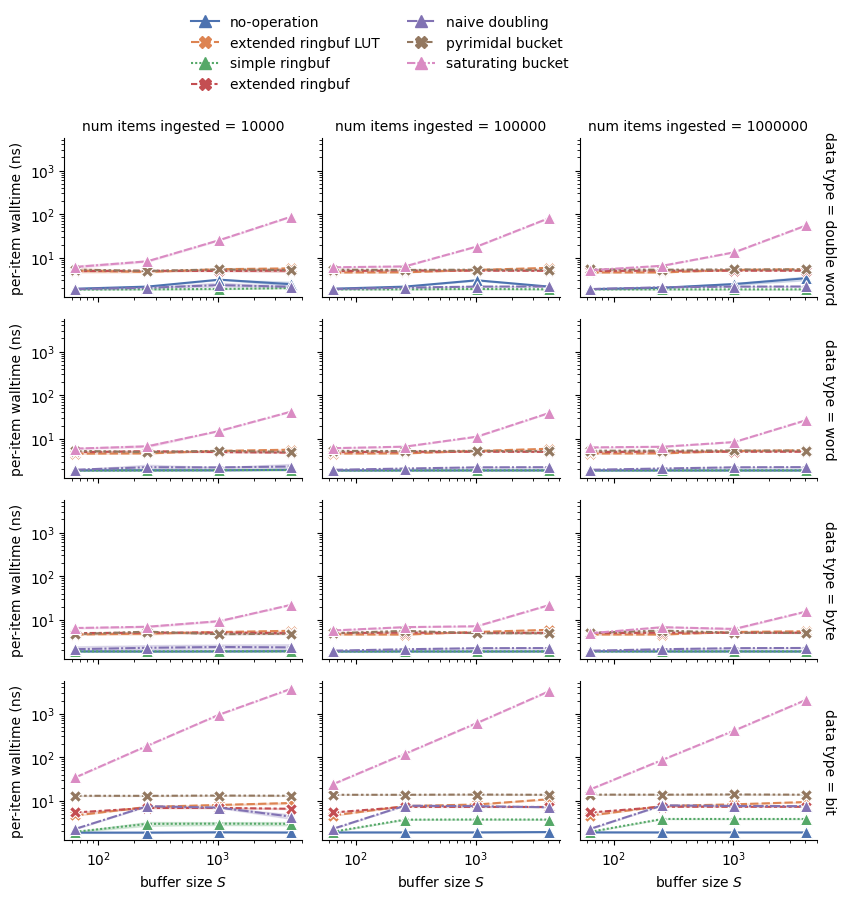

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: 
The markers list has fewer values (2) than needed (7) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-30-cpp-bench-speed-tilted/col=num-items-ingested+font.family=serif+hue=algorithm+kind=line+platform=arm-apple-m1+row=data-type+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pdf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=num-items-ingested+font.family=serif+hue=algorithm+kind=line+platform=arm-apple-m1+row=data-type+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pgf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=num-items-ingested+font.family=serif+hue=algorithm+kind=line+platform=arm-apple-m1+row=data-type+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.png


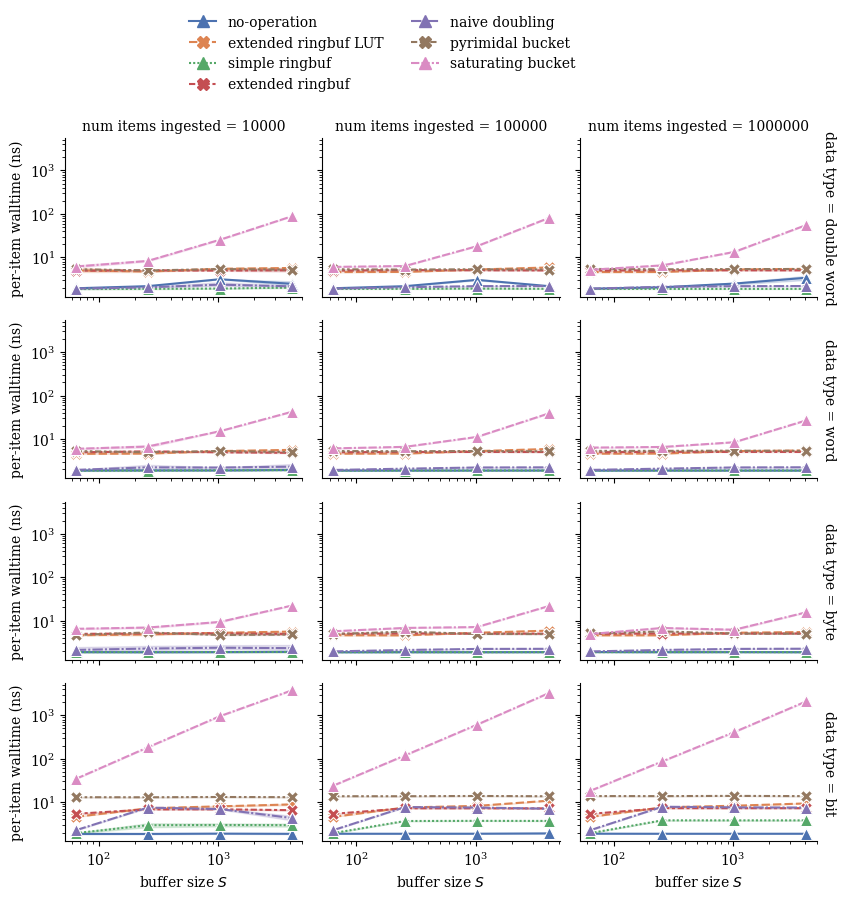

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: 
The markers list has fewer values (2) than needed (7) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-30-cpp-bench-speed-tilted/col=num-items-ingested+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+row=data-type+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pdf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=num-items-ingested+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+row=data-type+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pgf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=num-items-ingested+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+row=data-type+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.png


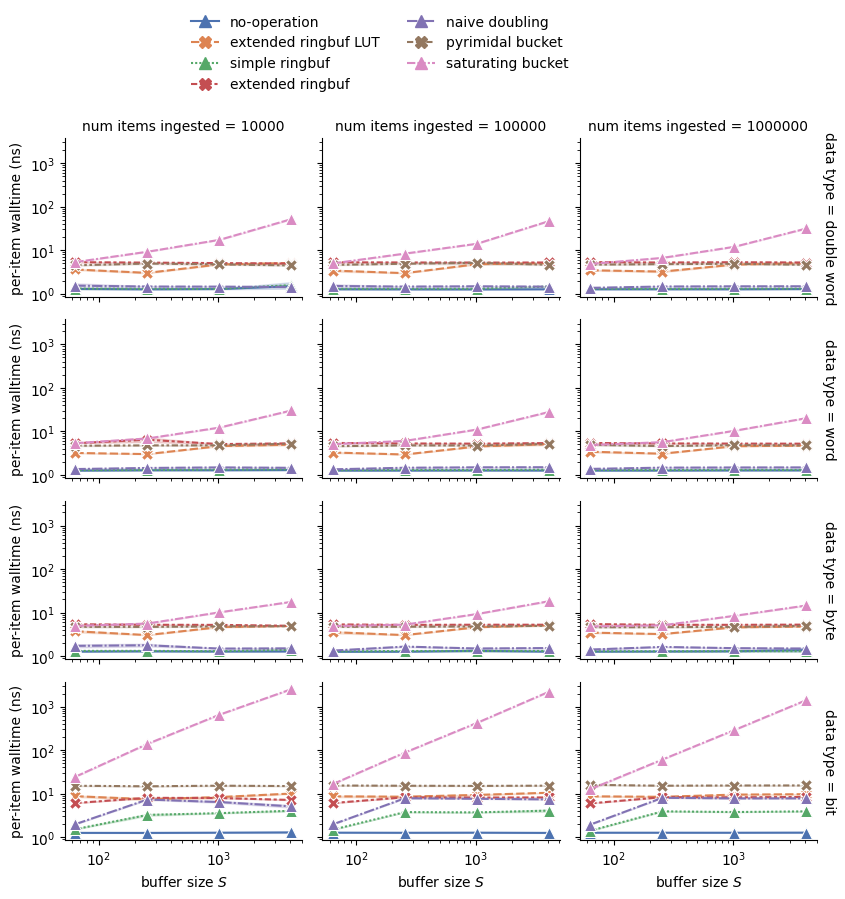

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: 
The markers list has fewer values (2) than needed (7) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-30-cpp-bench-speed-tilted/col=num-items-ingested+font.family=serif+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+row=data-type+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pdf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=num-items-ingested+font.family=serif+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+row=data-type+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pgf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=num-items-ingested+font.family=serif+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+row=data-type+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.png


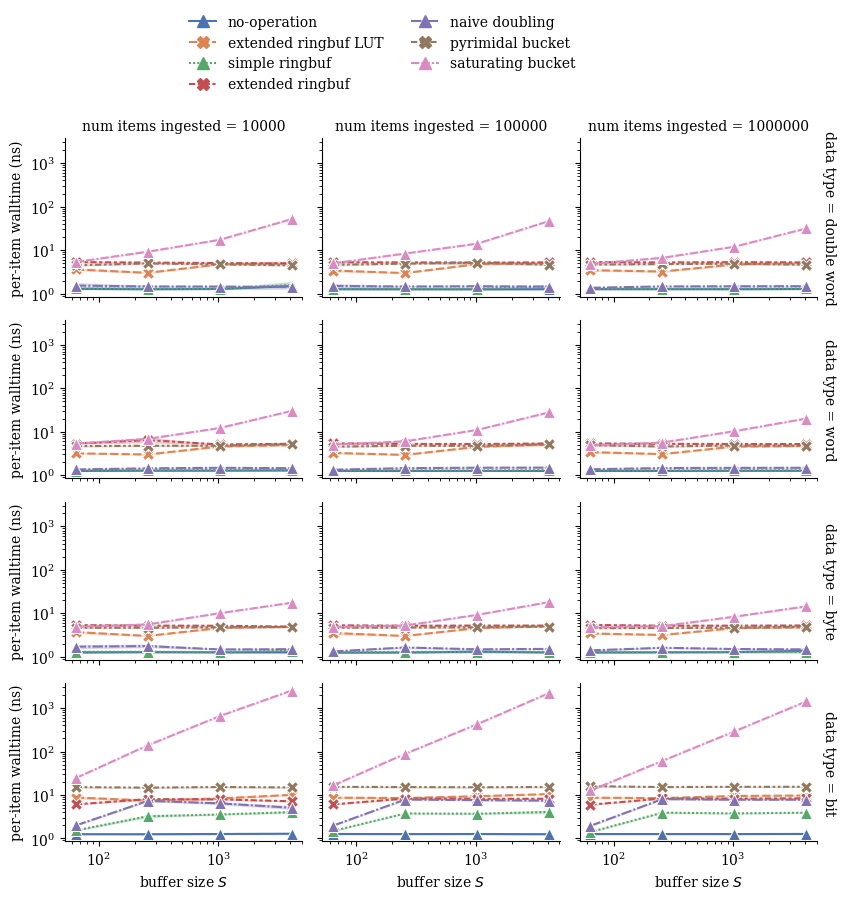

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: 
The markers list has fewer values (2) than needed (7) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-30-cpp-bench-speed-tilted/col=num-items-ingested+hue=algorithm+kind=line+platform=arm-cortex-m0+row=data-type+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pdf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=num-items-ingested+hue=algorithm+kind=line+platform=arm-cortex-m0+row=data-type+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pgf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=num-items-ingested+hue=algorithm+kind=line+platform=arm-cortex-m0+row=data-type+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.png


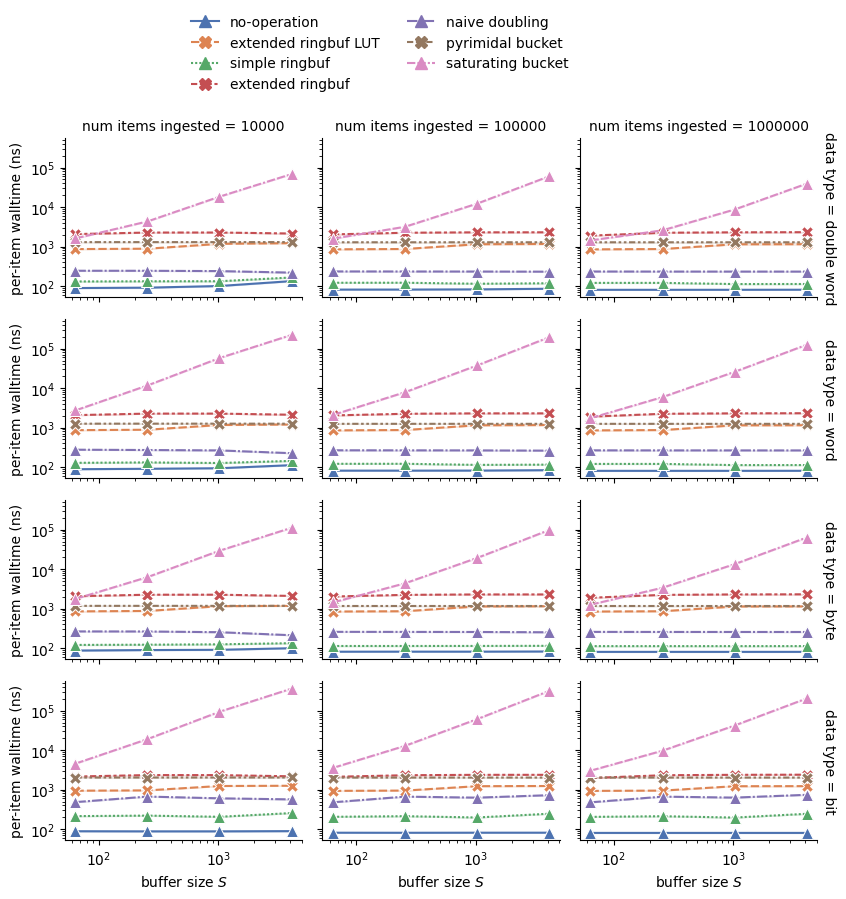

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: 
The markers list has fewer values (2) than needed (7) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-30-cpp-bench-speed-tilted/col=num-items-ingested+font.family=serif+hue=algorithm+kind=line+platform=arm-cortex-m0+row=data-type+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pdf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=num-items-ingested+font.family=serif+hue=algorithm+kind=line+platform=arm-cortex-m0+row=data-type+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pgf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=num-items-ingested+font.family=serif+hue=algorithm+kind=line+platform=arm-cortex-m0+row=data-type+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.png


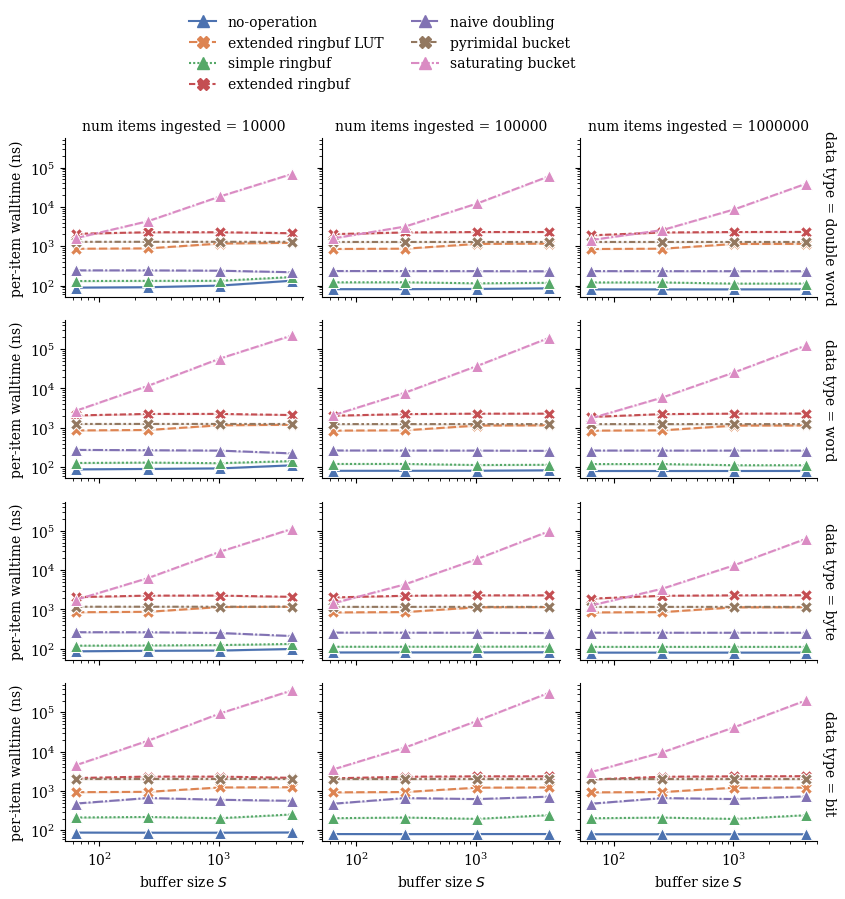

In [9]:
for platform, rc in it.product(platforms, [{}, {"font.family": "serif"}]):
    with mpl.rc_context(rc=rc):
        display(HTML(f"<h2>{platform}</h2>"))
        with tp.teed(
            sns.relplot,
            data=df.filter(
                pl.col("platform") == platform,
            ).with_columns(
                pl.col("num_sites").alias("buffer size $S$"),
                pl.col("duration_per_item_ns").alias("per-item walltime (ns)"),
                pl.col("num_items").alias("num items ingested"),
            ),
            x="buffer size $S$",
            y="per-item walltime (ns)",
            col="num items ingested",
            row="data type",
            hue="algorithm",
            style="algorithm",
            palette=palette,
            kind="line",
            aspect=1.5,
            markers=["^", "X"],
            ms=8,
            height=2,
            teeplot_outattrs={
                "platform": slugify(platform),
                **rc,
            },
            teeplot_subdir=teeplot_subdir,
            facet_kws=dict(margin_titles=True),
        ) as g:
            g.set(xscale="log", yscale="log")
            sns.move_legend(
                g,
                "lower center",
                bbox_to_anchor=(0.35, 1),
                ncol=2,
                title=None,
                frameon=False,
            )
            g.tight_layout()


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pdf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pgf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.png


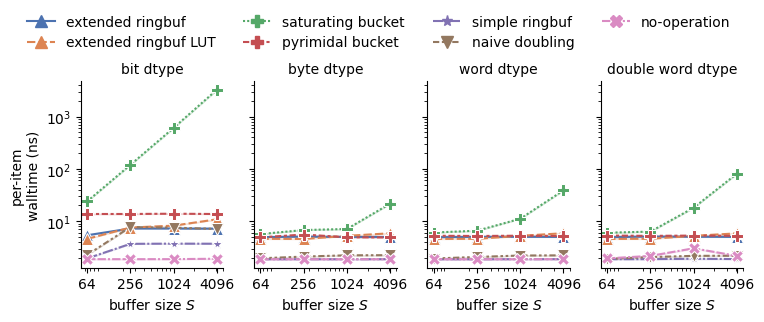

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pdf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pgf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.png


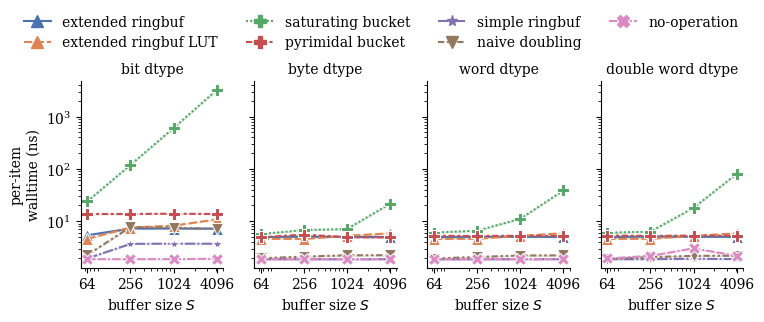

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pdf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pgf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.png


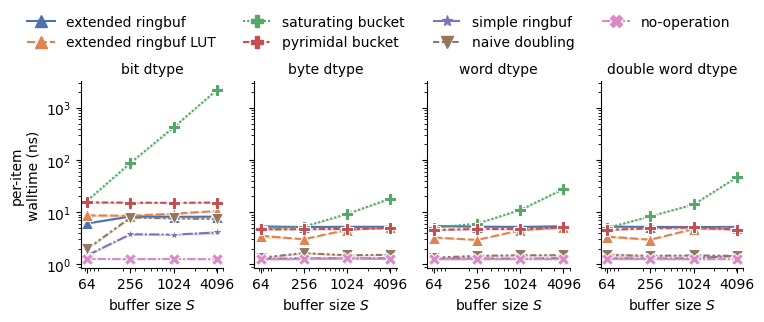

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pdf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pgf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.png


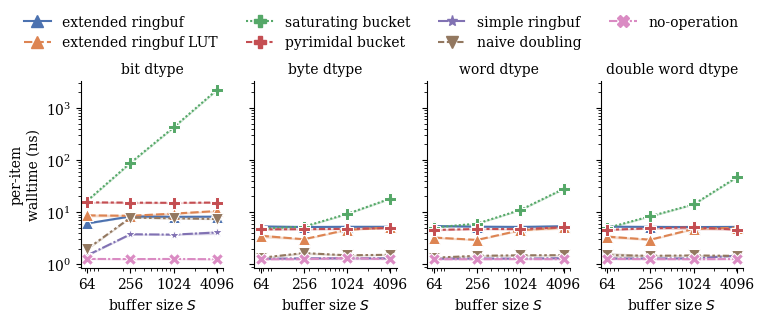

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pdf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pgf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.png


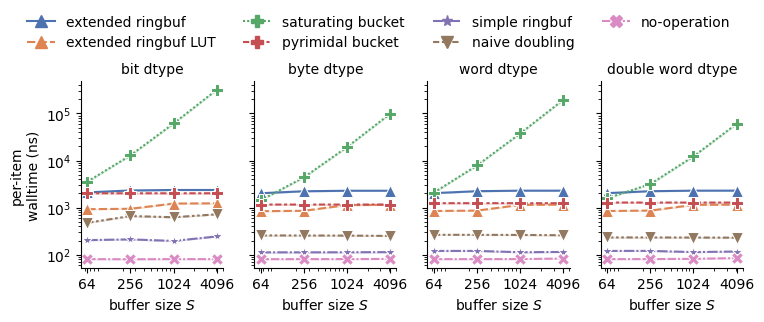

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pdf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pgf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.png


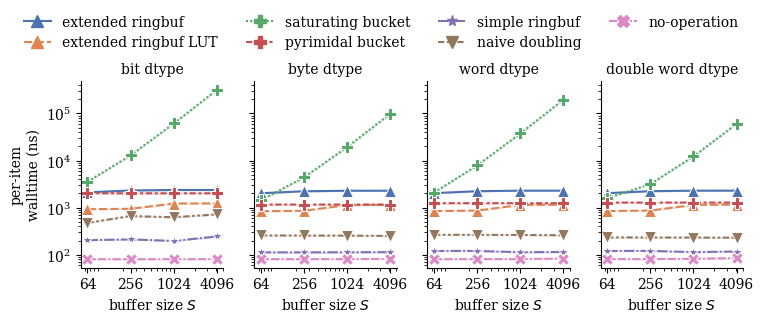

In [10]:
for platform, rc in it.product(platforms, [{}, {"font.family": "serif"}]):
    display(HTML(f"<h2>{platform=}</h2>"))
    with mpl.rc_context(rc=rc):
        with tp.teed(
            sns.relplot,
            data=df.filter(
                pl.col("num_items") == 100_000,
                pl.col("platform") == platform,
            ).with_columns(
                pl.col("num_sites").alias("buffer size $S$"),
                pl.col("duration_per_item_ns").alias("per-item\nwalltime (ns)"),
                pl.col("num_items").alias("num items ingested"),
            ),
            x="buffer size $S$",
            y="per-item\nwalltime (ns)",
            col="data type",
            col_order=[
                "bit",
                "byte",
                "word",
                "double word",
            ],
            hue="algorithm",
            hue_order=hue_order,
            style="algorithm",
            style_order=hue_order,
            palette=palette,
            kind="line",
            aspect=0.7,
            markers=["^", "^", "P", "P", "*", "v", "X"],
            ms=8,
            height=2.8,
            teeplot_outattrs={
                "platform": slugify(platform),
                **rc,
            },
            teeplot_subdir=teeplot_subdir,
            facet_kws=dict(margin_titles=False),
        ) as g:
            g.set(xscale="log", yscale="log")
            g.set_titles(col_template="{col_name} dtype")
            sns.move_legend(
                g,
                "upper center",
                bbox_to_anchor=(0.39, 1.16),
                ncol=4,
                title=None,
                frameon=False,
            )
            for ax in g.axes.flat:
                ax.set_xticks([64, 256, 1024, 4096])
                ax.set_xticklabels(["64", "256", "1024", "4096"])
            g.tight_layout()


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


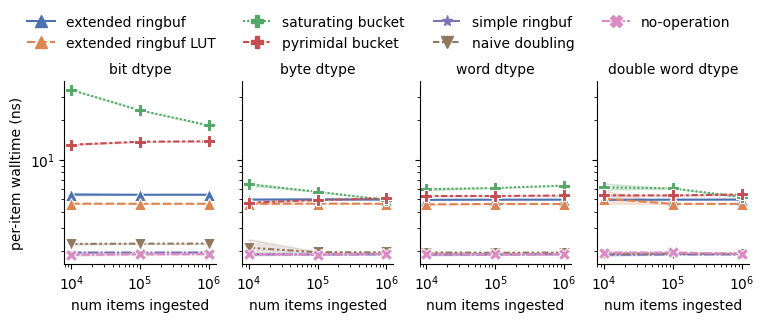

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


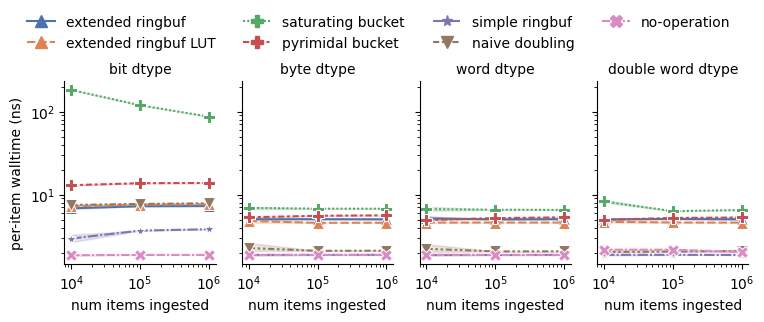

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


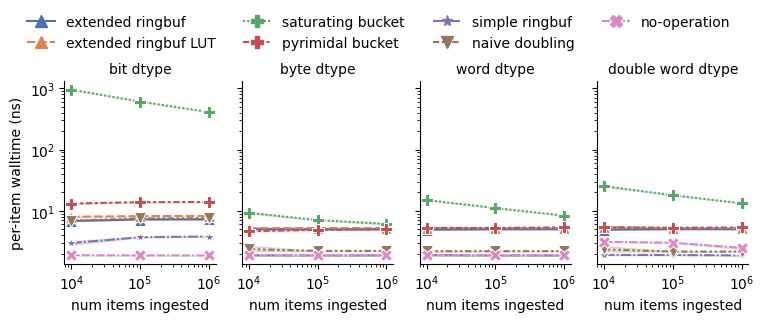

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


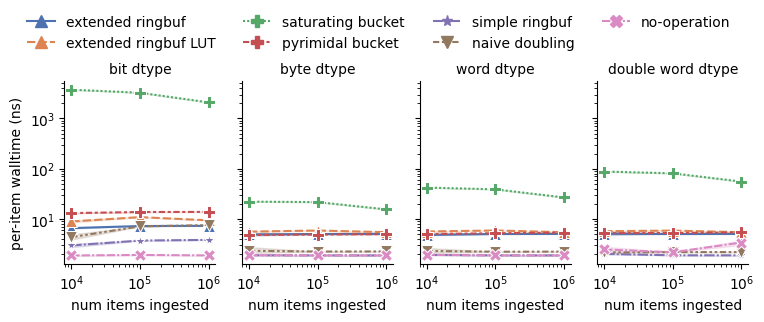

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


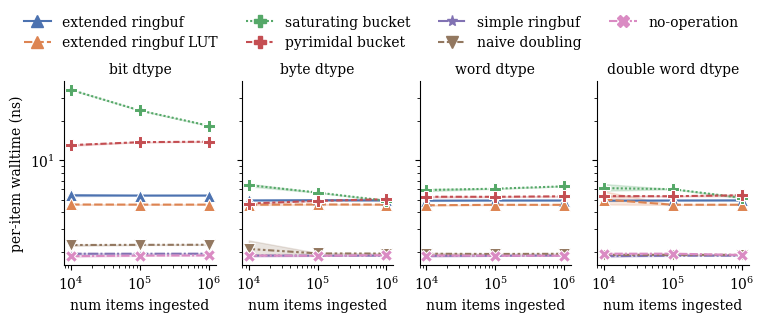

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


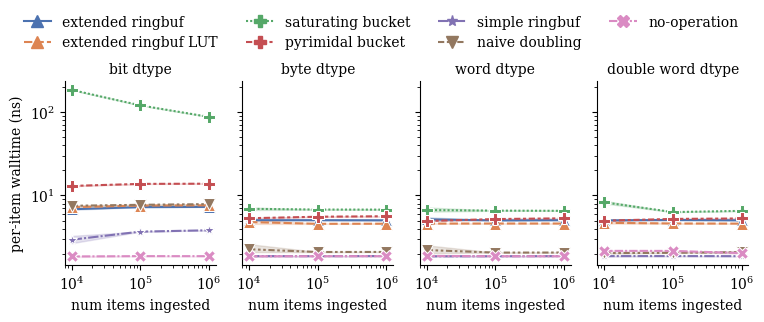

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


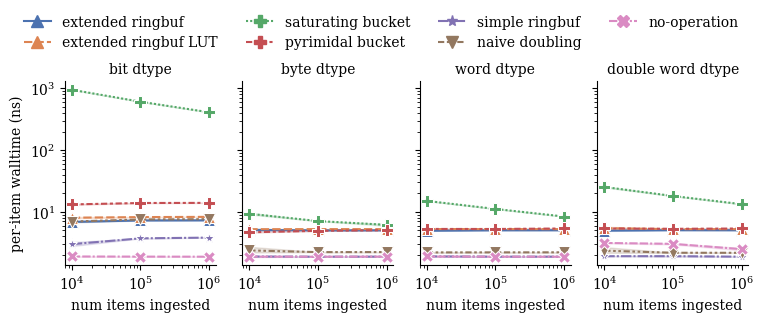

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-apple-m1+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


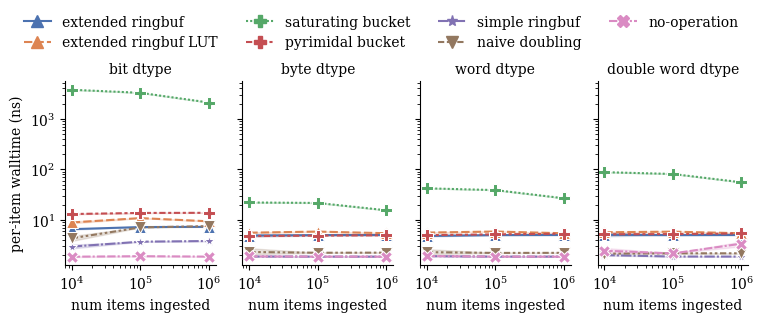

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


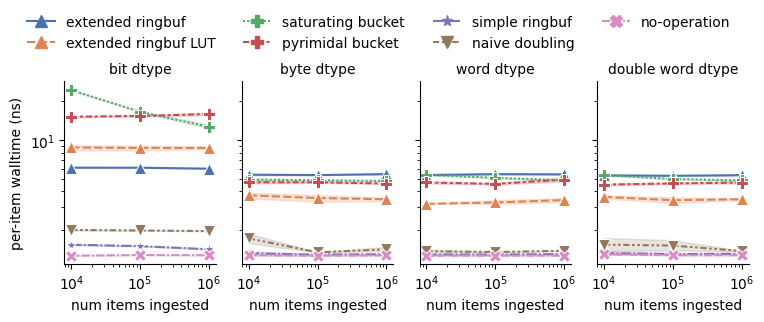

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


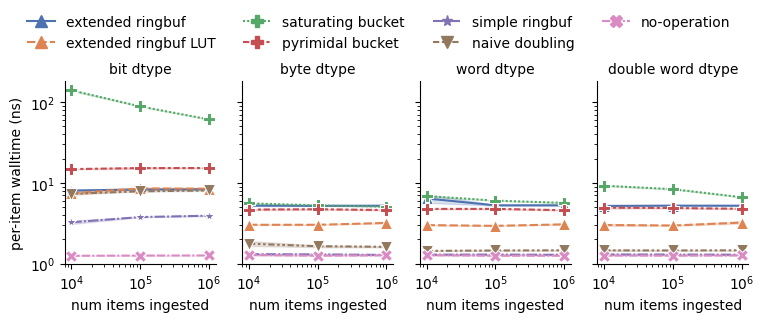

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


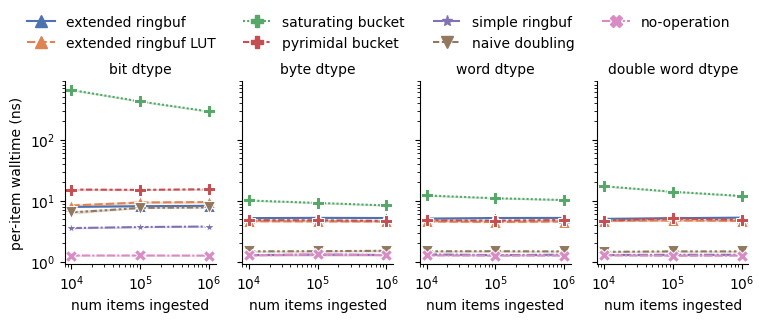

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


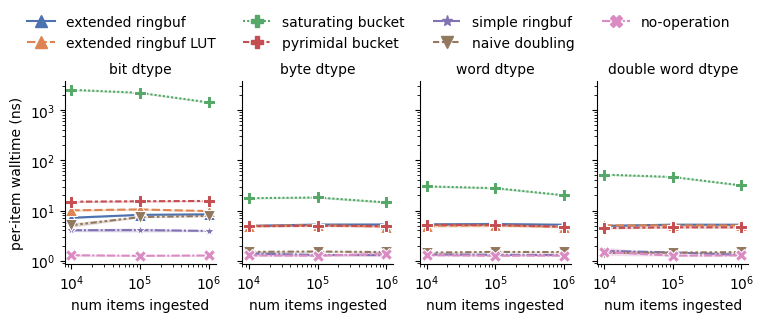

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


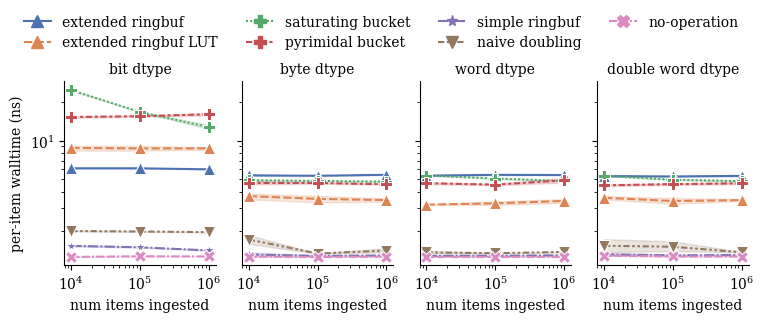

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


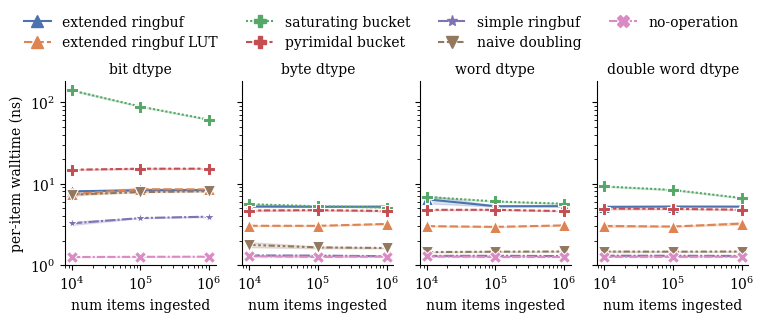

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


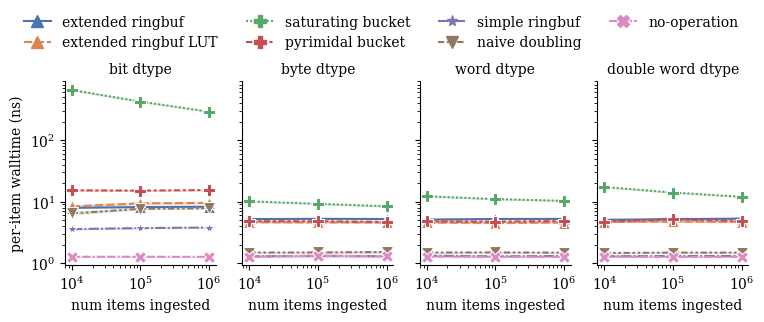

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=x86-intel-core-ultra-7-155u+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


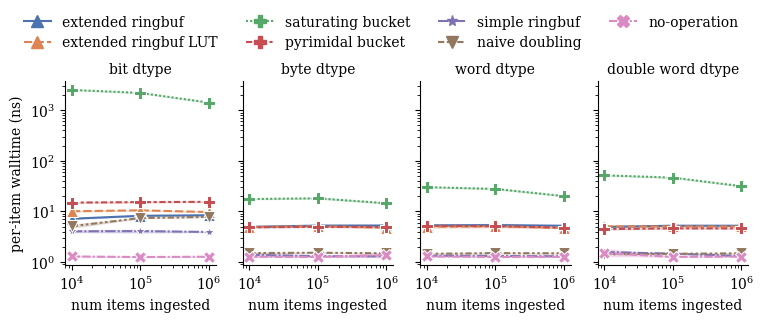

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


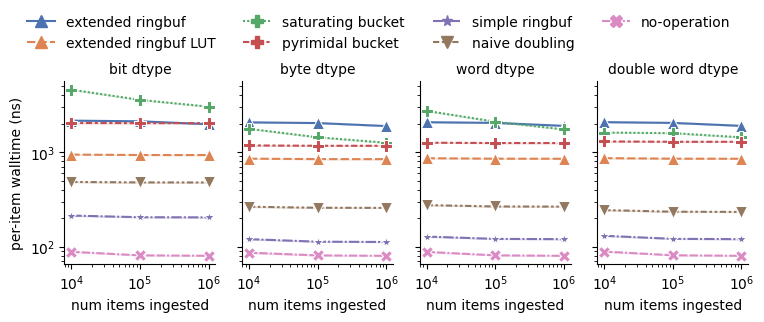

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


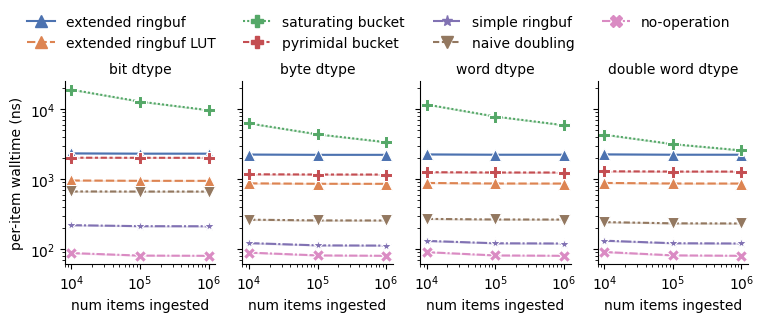

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


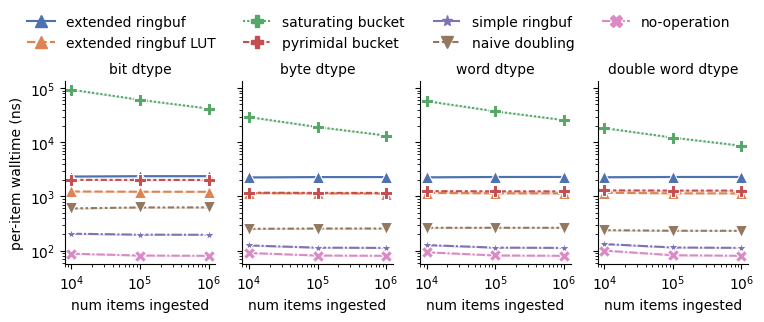

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


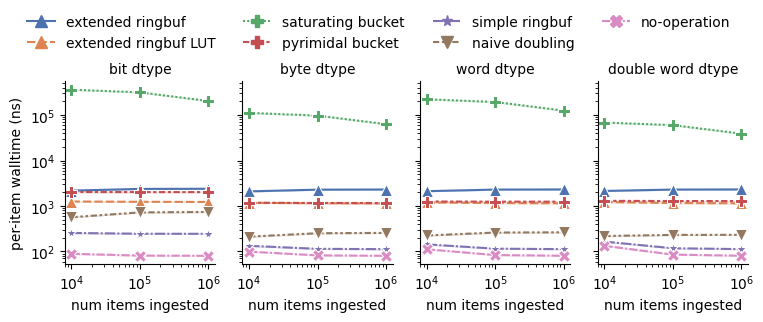

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf
teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


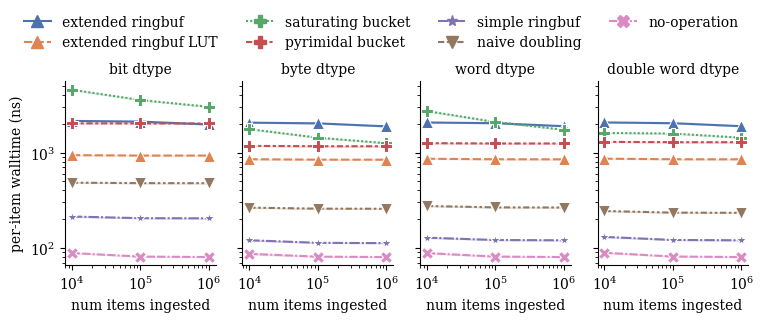

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


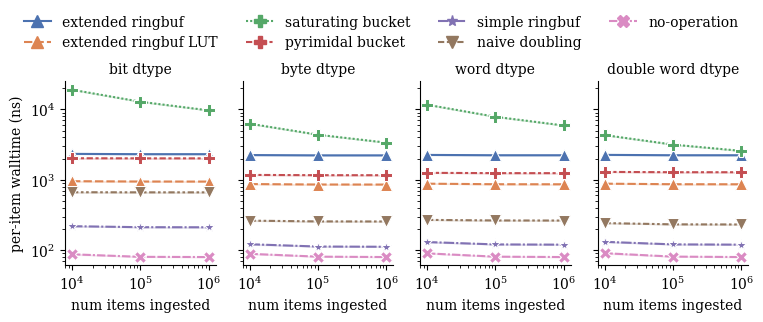

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


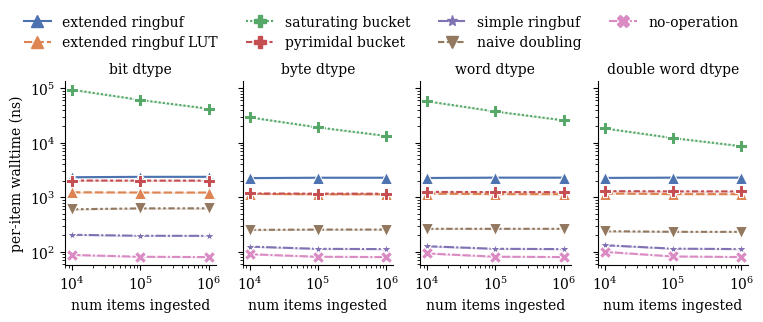

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-speed-tilted/col=data-type+font.family=serif+hue=algorithm+kind=line+platform=arm-cortex-m0+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


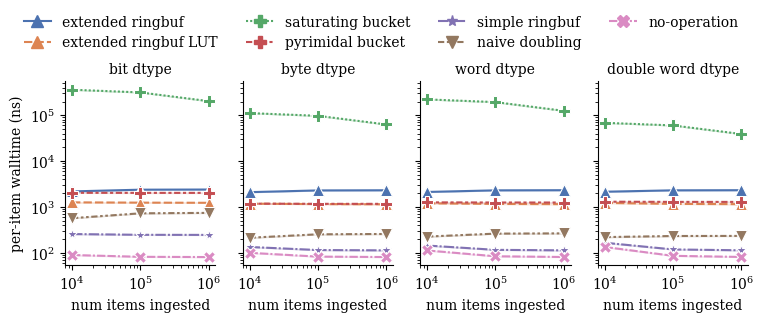

In [11]:
for platform, rc in it.product(platforms, [{}, {"font.family": "serif"}]):
    with mpl.rc_context(rc=rc):
        for num_sites in [64, 256, 1024, 4096]:
            display(HTML(f"<h2>{platform=} {num_sites=}</h2>"))
            with tp.teed(
                sns.relplot,
                data=df.filter(
                    pl.col("num_sites") == num_sites,
                    pl.col("platform") == platform,
                ).with_columns(
                    pl.col("num_sites").alias("buffer size $S$"),
                    pl.col("duration_per_item_ns").alias("per-item walltime (ns)"),
                    pl.col("num_items").alias("num items ingested"),
                ),
                x="num items ingested",
                y="per-item walltime (ns)",
                col="data type",
                col_order=[
                    "bit",
                    "byte",
                    "word",
                    "double word",
                ],
                hue="algorithm",
                hue_order=hue_order,
                style="algorithm",
                style_order=hue_order,
                palette=palette,
                kind="line",
                aspect=0.7,
                markers=["^", "^", "P", "P", "*", "v", "X"],
                ms=8,
                height=2.8,
                teeplot_outattrs={
                    "platform": slugify(platform),
                    **rc,
                },
                teeplot_subdir=teeplot_subdir,
                facet_kws=dict(margin_titles=False),
            ) as g:
                g.set(xscale="log", yscale="log")
                g.set_titles(col_template="{col_name} dtype")
                sns.move_legend(
                    g,
                    "upper center",
                    bbox_to_anchor=(0.39, 1.16),
                    ncol=4,
                    title=None,
                    frameon=False,
                )
                g.tight_layout()
